## Celltype prediction
***

 Celltype prediction can either be performed on indiviudal cells where each cell gets a predicted celltype label, or on the level of clusters. All methods are based on similarity to other datasets, single cell or sorted bulk RNAseq, or uses know marker genes for each celltype.

We will select one sample from the Covid data, `ctrl_13` and predict celltype by cell on that sample.

Some methods will predict a celltype to each cell based on what it is most similar to even if the celltype of that cell is not included in the reference. Other methods include an uncertainty so that cells with low similarity scores will be unclassified.
There are multiple different methods to predict celltypes, here we will just cover a few of those. 

Here we will use a reference PBMC dataset that we get from scanpy datasets and classify celltypes based on two methods:

* Using scanorama for integration just as in the integration lab, and then do label transfer based on closest neighbors.
* Using ingest to project the data onto the reference data and transfer labels.



In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()


In [2]:
sc.settings.set_figure_params(dpi=80)

Read in the clustered data object.

In [3]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [4]:
print(adata.shape)
print(adata.raw.shape)

(5594, 3067)
(5594, 18752)


Subset for `ctrl_13` sample.

In [5]:
adata = adata[adata.obs["sample"] == "ctrl_13",:]
print(adata.shape)

(1124, 3067)


Trying to set attribute `._uns` of view, copying.


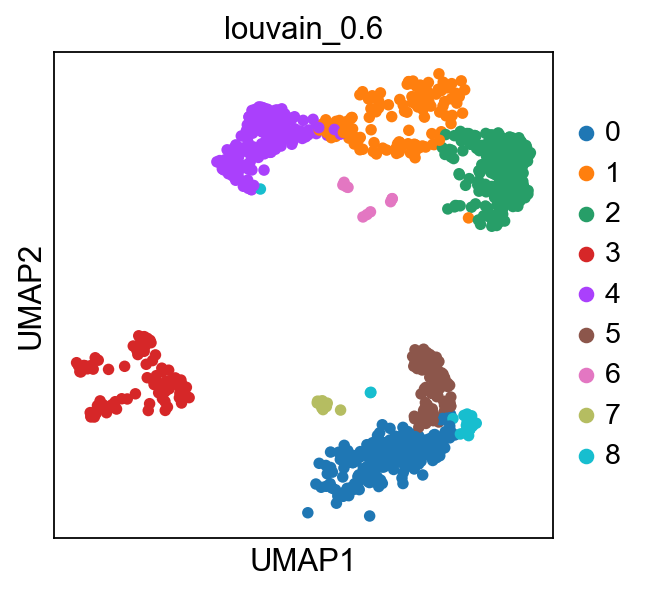

In [6]:
sc.pl.umap(
    adata, color=["louvain_0.6"], palette=sc.pl.palettes.default_20
)

### Reference data

Load the reference data from `scanpy.datasets`. It is the annotated and processed pbmc3k dataset from 10x.

In [7]:

adata_ref = sc.datasets.pbmc3k_processed() 

In [8]:
adata_ref.obs['sample']='pbmc3k'

print(adata_ref.shape)
adata_ref.obs

(2638, 1838)


,n_genes,percent_mito,n_counts,louvain,sample
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,pbmc3k
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,pbmc3k
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,pbmc3k
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,pbmc3k
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,pbmc3k
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,pbmc3k
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,pbmc3k
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,pbmc3k


/Users/asbj/miniconda3/envs/scRNAseq2022_tmp/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical


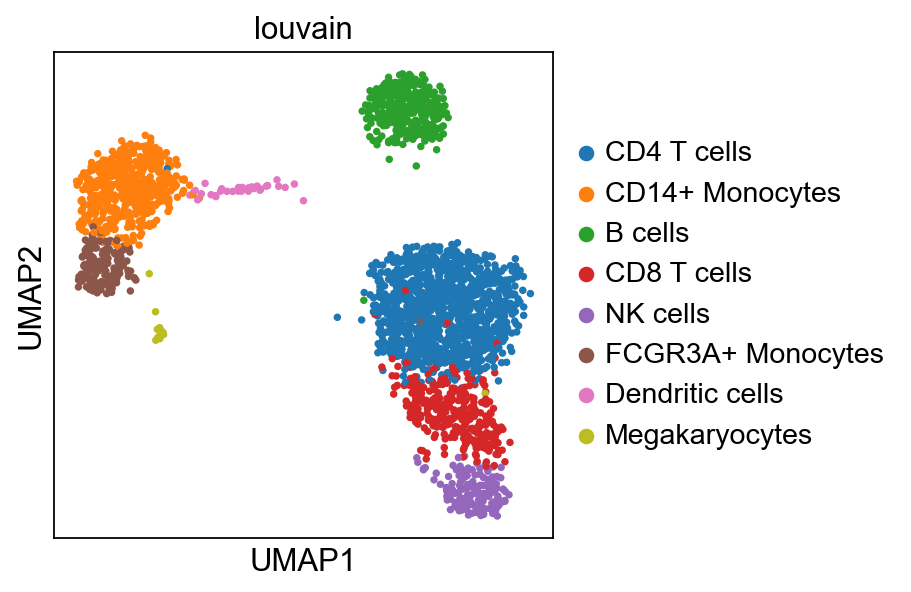

In [9]:
sc.pl.umap(adata_ref, color='louvain')

Make sure we have the same genes in both datset by taking the intersection

In [10]:
print(adata_ref.shape[1])
print(adata.shape[1])
var_names = adata_ref.var_names.intersection(adata.var_names)
print(len(var_names))

1838
3067
477


In [11]:
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]


First we need to rerun pca and umap with the same gene set for both datasets.

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:07)
computing UMAP
    finished (0:00:06)


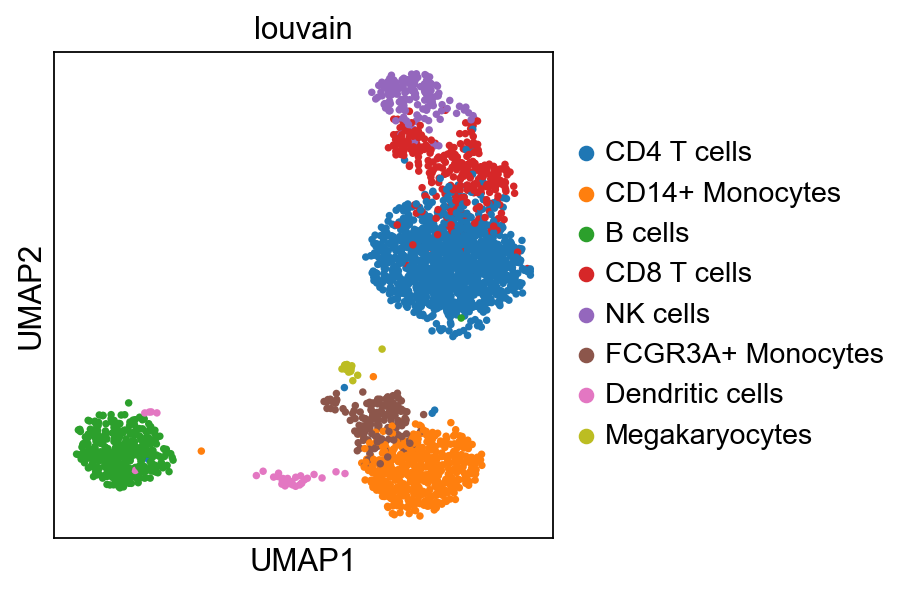

In [12]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color='louvain')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:02)


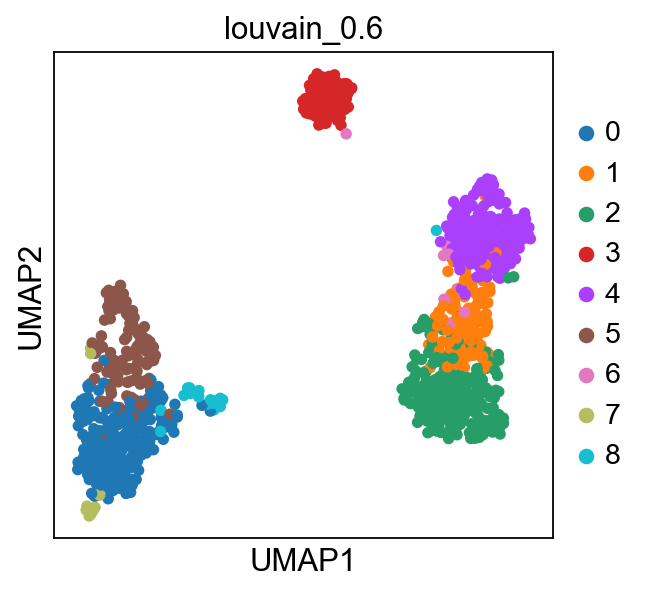

In [13]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='louvain_0.6')

## Integrate with scanorama

In [14]:
import scanorama


#subset the individual dataset to the same variable genes as in MNN-correct.
alldata = dict()
alldata['ctrl']=adata
alldata['ref']=adata_ref

#convert to list of AnnData objects
adatas = list(alldata.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

Found 477 genes among all datasets
[[0.         0.96530249]
 [0.         0.        ]]
Processing datasets (0, 1)


In [15]:
# add in sample info
adata_ref.obs['sample']='pbmc3k'


In [16]:
# create a merged scanpy object and add in the scanorama 
adata_merged = alldata['ctrl'].concatenate(alldata['ref'], batch_key='sample', batch_categories=['ctrl','pbmc3k'])

embedding = np.concatenate([ad.obsm['X_scanorama'] for ad in adatas], axis=0)

adata_merged.obsm['Scanorama'] = embedding

In [17]:
#run  umap.
sc.pp.neighbors(adata_merged, n_pcs =50, use_rep = "Scanorama")
sc.tl.umap(adata_merged)



computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:07)


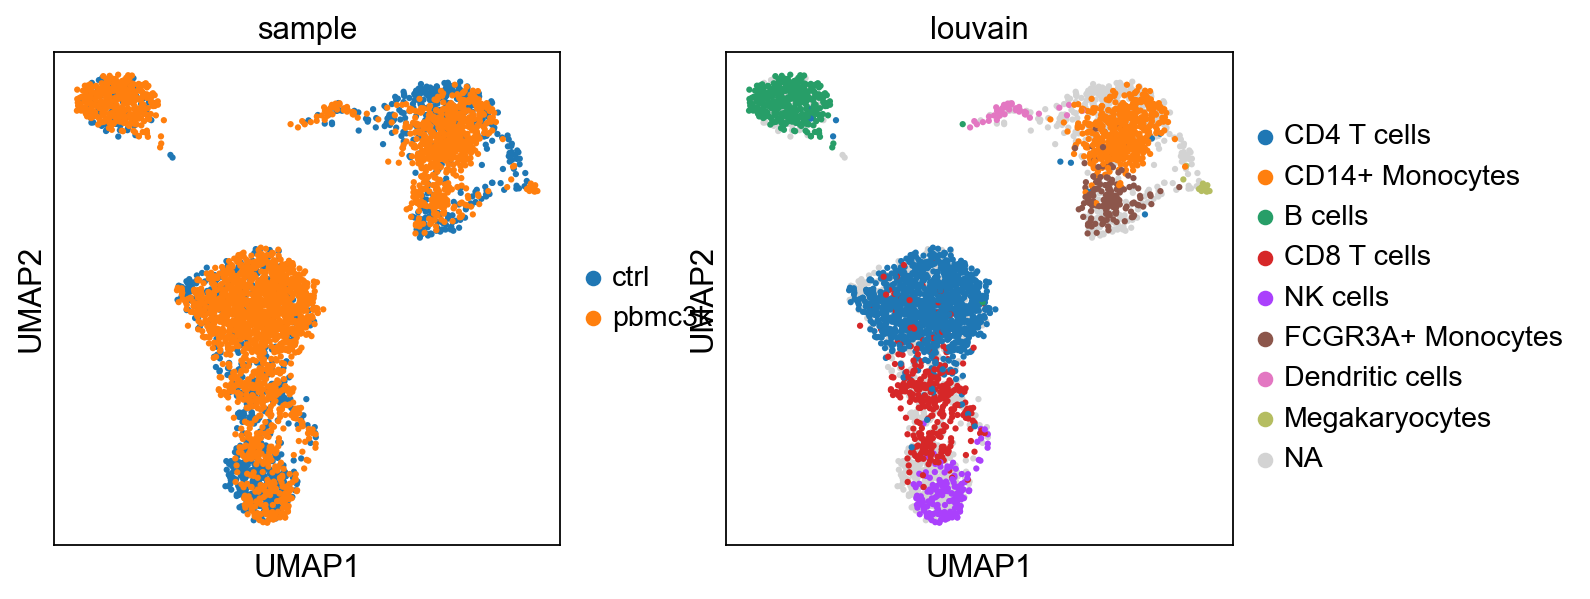

In [18]:

sc.pl.umap(adata_merged, color=["sample","louvain"])


### Label transfer

Using the function in the Spatial tutorial at the scanpy [website](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html) we will calculate normalized cosine distances between the two datasets and tranfer labels to the celltype with the highest scores.


In [19]:
from sklearn.metrics.pairwise import cosine_distances

distances = 1 - cosine_distances(
    adata_merged[adata_merged.obs['sample'] == "pbmc3k"].obsm["Scanorama"],
    adata_merged[adata_merged.obs['sample'] == "ctrl"].obsm["Scanorama"],
)

In [20]:
def label_transfer(dist, labels, index):
    lab = pd.get_dummies(labels)
    class_prob = lab.to_numpy().T @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    # convert to df
    cp_df = pd.DataFrame(
        class_prob, columns=lab.columns
    )
    cp_df.index = index
    # classify as max score
    m = cp_df.idxmax(axis=1)
    
    return m

In [21]:
class_def = label_transfer(distances, adata_ref.obs.louvain, adata.obs.index)


In [22]:
# add to obs section of the original object
adata.obs['predicted'] = class_def


/Users/asbj/miniconda3/envs/scRNAseq2022_tmp/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted' as categorical


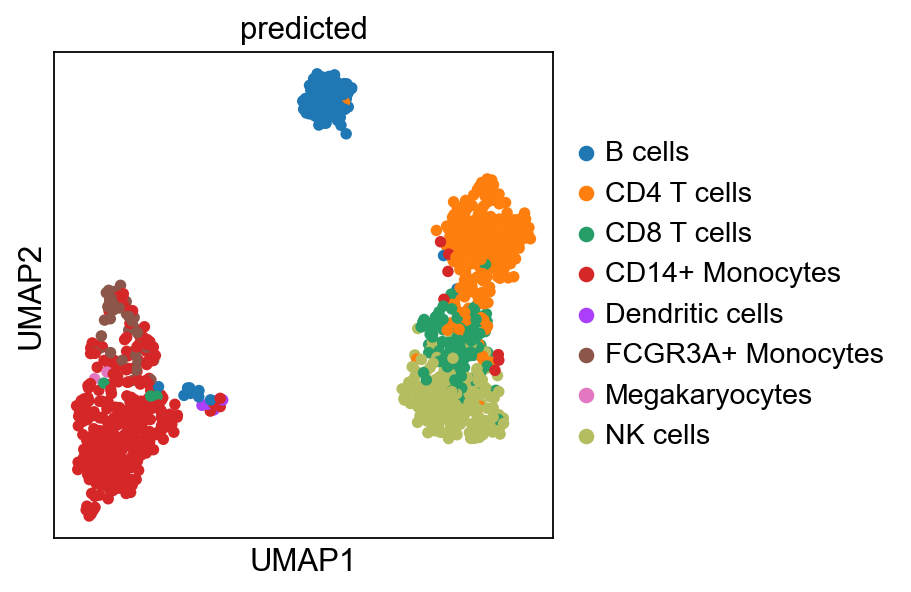

In [23]:
sc.pl.umap(adata, color="predicted")

/Users/asbj/miniconda3/envs/scRNAseq2022_tmp/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted' as categorical


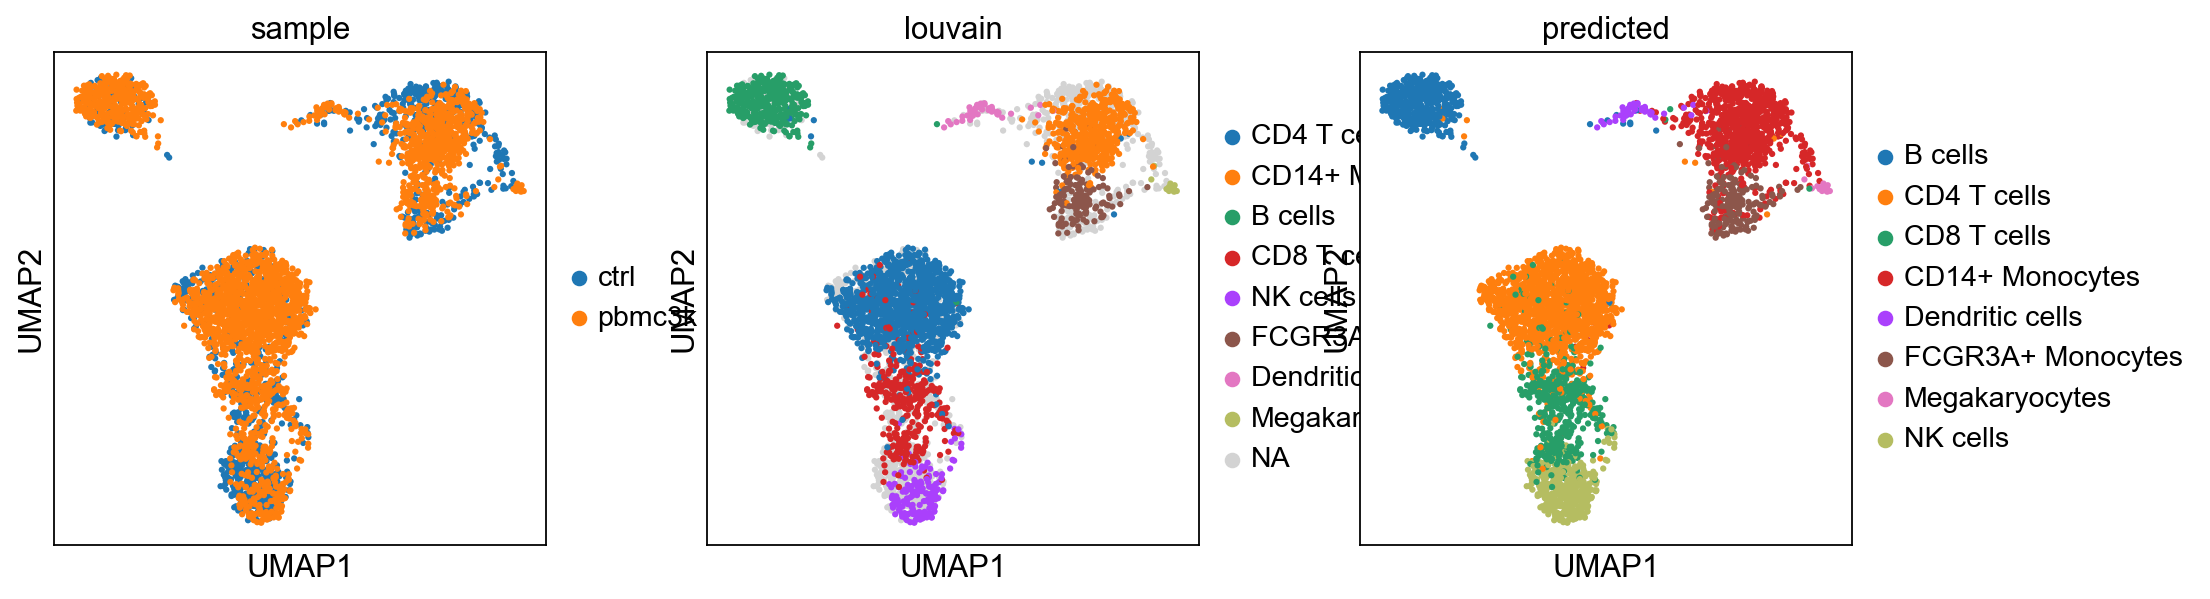

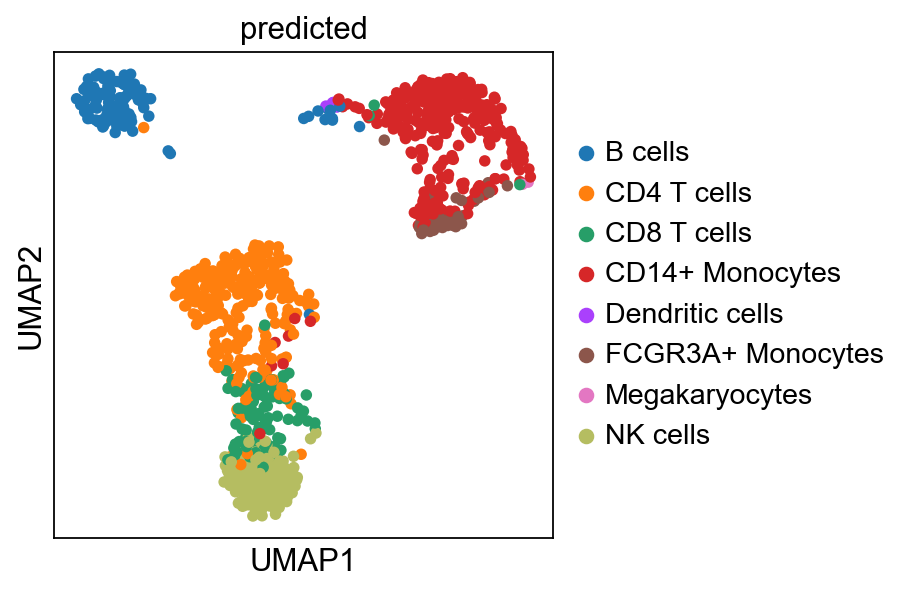

In [24]:
# add to merged object.
adata_merged.obs['predicted'] = class_def.append(adata_ref.obs['louvain']).tolist()

sc.pl.umap(adata_merged, color=["sample","louvain",'predicted'])
#plot only ctrl cells.
sc.pl.umap(adata_merged[adata_merged.obs['sample']=='ctrl'], color='predicted')

##Ingest

In [25]:
sc.tl.ingest(adata, adata_ref, obs='louvain')

running ingest
    finished (0:00:34)


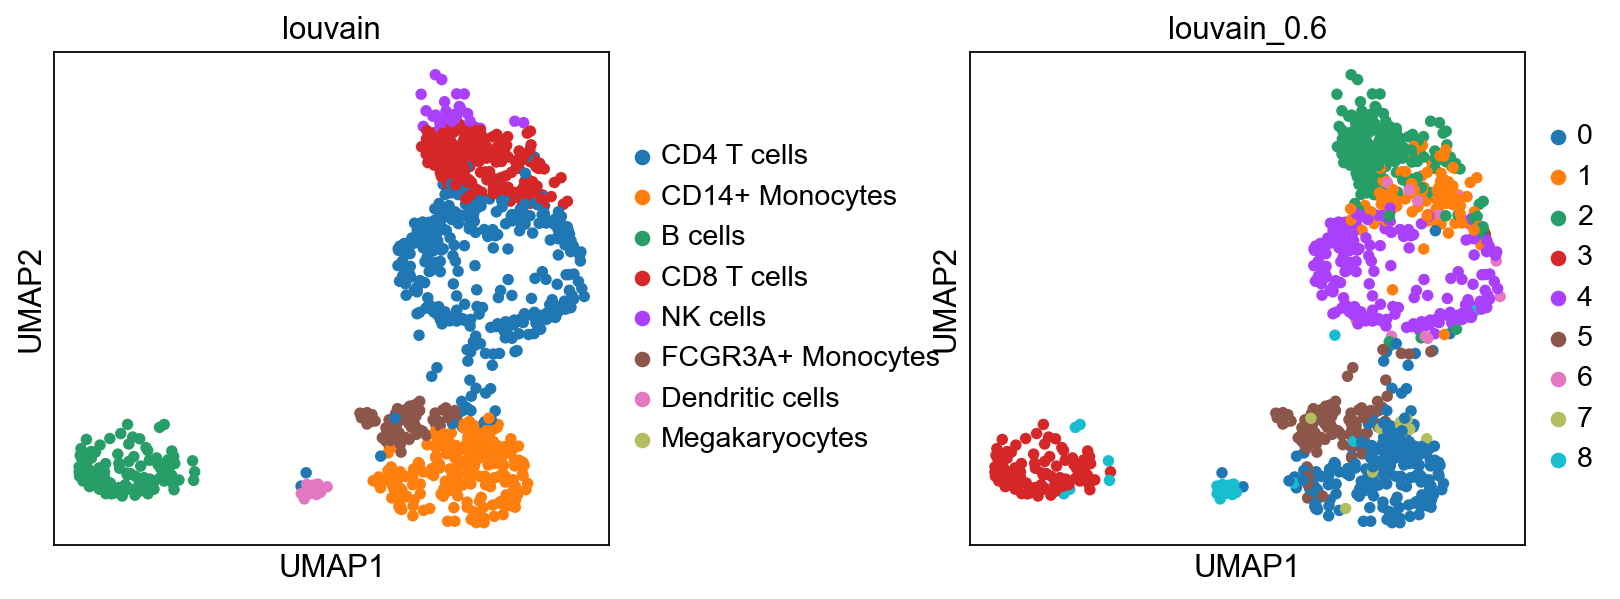

In [26]:
sc.pl.umap(adata, color=['louvain','louvain_0.6'], wspace=0.5)

## Compare results

The predictions from ingest is stored in the column 'louvain' while we named the label transfer with scanorama as 'predicted'

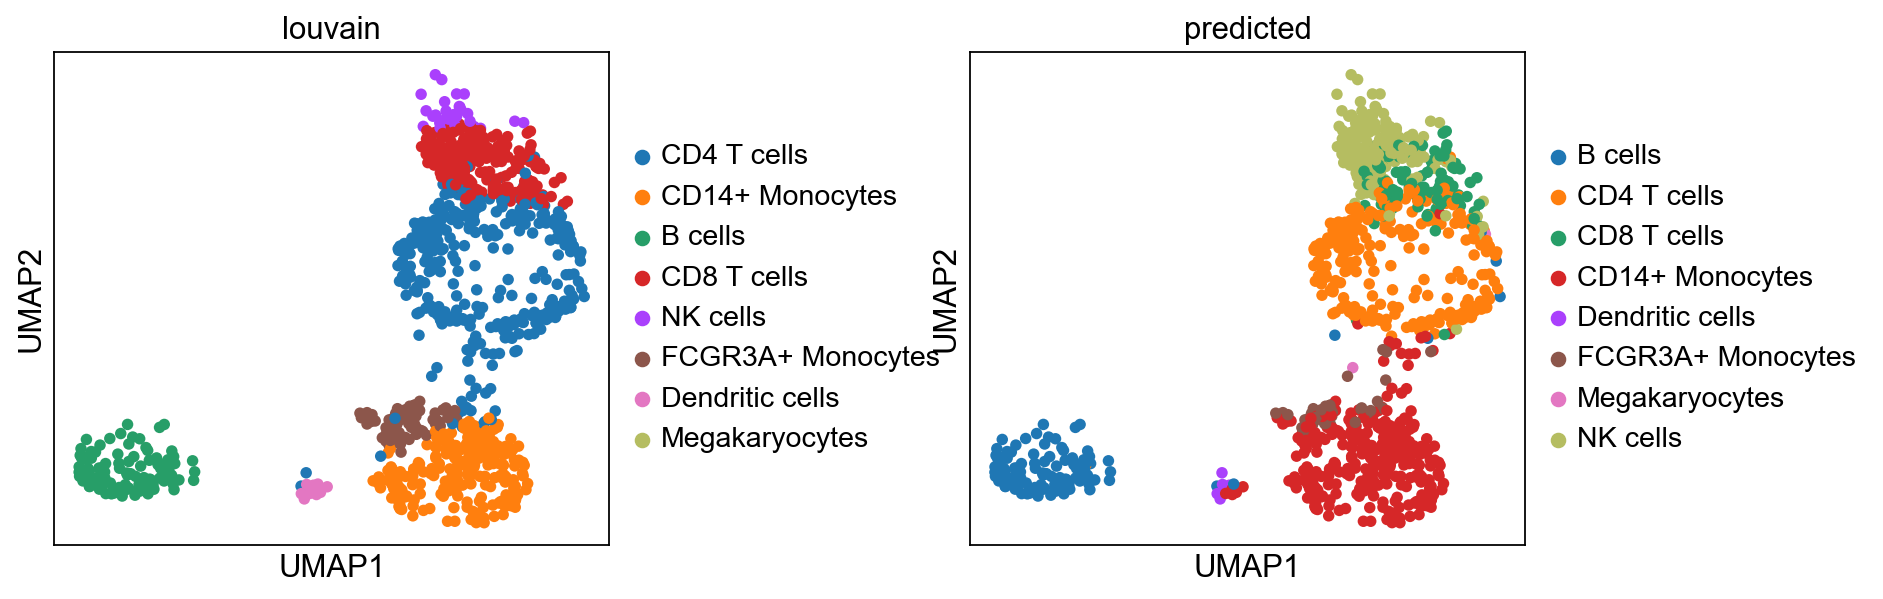

In [27]:
sc.pl.umap(adata, color=['louvain','predicted'], wspace=0.5)

As you can see, the main celltypes are the same, but dendritic cells are mainly predicted to cluster 8 by ingest and the proportions of the different celltypes are different. 

The only way to make sure which method you trust is to look at what genes the different celltypes express and use your biological knowledge to make decisions. 


In [28]:
df = pd.read_table('./data/CellMarker_list/Human_cell_markers.txt')
df

,speciesType,tissueType,UberonOntologyID,cancerType,cellType,cellName,CellOntologyID,cellMarker,geneSymbol,geneID,proteinName,proteinID,markerResource,PMID,Company
0,Human,Kidney,UBERON_0002113,Normal,Normal cell,Proximal tubular cell,NaN,Intestinal Alkaline Phosphatase,ALPI,248,PPBI,P09923,Experiment,9263997,NaN
1,Human,Liver,UBERON_0002107,Normal,Normal cell,Ito cell (hepatic stellate cell),CL_0000632,Synaptophysin,SYP,6855,SYPH,P08247,Experiment,10595912,NaN
2,Human,Endometrium,UBERON_0001295,Normal,Normal cell,Trophoblast cell,CL_0000351,CEACAM1,CEACAM1,634,CEAM1,P13688,Experiment,10751340,NaN
3,Human,Germ,UBERON_0000923,Normal,Normal cell,Primordial germ cell,CL_0000670,VASA,DDX4,54514,DDX4,Q9NQI0,Experiment,10920202,NaN
4,Human,Corneal epithelium,UBERON_0001772,Normal,Normal cell,Epithelial cell,CL_0000066,KLF6,KLF6,1316,KLF6,Q99612,Experiment,12407152,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2863,Human,Embryo,UBERON_0000922,Normal,Normal cell,1-cell stage cell (Blastomere),CL_0000353,"ACCSL, ACVR1B, ARHGEF16, ASF1B, BCL2L10, BLCAP...","ACCSL, ACVR1B, ARHGEF16, ASF1B, BCL2L10, BLCAP...","390110, 91, 27237, 55723, 10017, 10904, 662, 7...","1A1L2, ACV1B, ARHGG, ASF1B, B2L10, BLCAP, SEC2...","Q4AC99, P36896, Q5VV41, Q9NVP2, Q9HD36, P62952...",Single-cell sequencing,23892778,NaN
2864,Human,Embryo,UBERON_0000922,Normal,Normal cell,4-cell stage cell (Blastomere),CL_0000353,"ADPGK, AIM1, AIMP2, ARG2, ARHGAP17, ARIH1, CDC...","ADPGK, CRYBG1, AIMP2, ARG2, ARHGAP17, ARIH1, C...","83440, 202, 7965, 384, 55114, 25820, 55536, 24...","ADPGK, CRBG1, AIMP2, ARGI2, RHG17, ARI1, CDA7L...","Q9BRR6, Q9Y4K1, Q13155, P78540, Q68EM7, Q9Y4X5...",Single-cell sequencing,23892778,NaN
2865,Human,Embryo,UBERON_0000922,Normal,Normal cell,8-cell stage cell (Blastomere),CL_0000353,"C11orf48, C19orf53, DHX9, DIABLO, EIF1AD, EIF4...","LBHD1, C19orf53, DHX9, DIABLO, EIF1AD, EIF4G1,...","79081, 28974, 1660, 56616, 84285, 1981, 26017,...","LBHD1, L10K, DHX9, DBLOH, EIF1A, IF4G1, FA32A,...","Q9BQE6, Q9UNZ5, Q08211, Q9NR28, Q8N9N8, Q04637...",Single-cell sequencing,23892778,NaN
2866,Human,Embryo,UBERON_0000922,Normal,Normal cell,Morula cell (Blastomere),CL_0000360,"ADCK1, AGL, AIMP1, AKAP12, ARPC3, ATP1B3, ATP5...","ADCK1, AGL, AIMP1, AKAP12, ARPC3, ATP1B3, NA, ...","57143, 178, 9255, 9590, 10094, 483, NA, 586, 9...","ADCK1, GDE, AIMP1, AKA12, ARPC3, AT1B3, AT5F1,...","Q86TW2, P35573, Q12904, Q02952, O15145, P54709...",Single-cell sequencing,23892778,NaN


In [29]:
# Filter for number of genes.
print(df.shape)

df['nG'] = df.geneSymbol.str.split(",").str.len()

df = df[df['nG'] > 5]
df = df[df['nG'] < 100]
d = df[df['cancerType'] == "Normal"]
print(df.shape)


(2868, 15)
(445, 16)


In [30]:
df.index = df.cellName
gene_dict = df.geneSymbol.str.split(",").to_dict()


In [31]:
# run differential expression per cluster
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='wilcoxon', key_added = "wilcoxon")


ranking genes
    finished (0:00:01)


In [32]:
# do gene set overlap to the groups in the gene list and top 100 DEGs.

import gseapy

gsea_res = dict()
pred = dict()

for cl in adata.obs['louvain_0.6'].cat.categories.tolist():
    print(cl)
    glist = sc.get.rank_genes_groups_df(adata, group=cl, key='wilcoxon')['names'].squeeze().str.strip().tolist()    
    enr_res = gseapy.enrichr(gene_list=glist[:100],
                     organism='Human',
                     gene_sets=gene_dict,
                     background = adata.raw.shape[1],    
                     description='pathway',
                     cutoff = 1)
    if enr_res.results.shape[0] == 0:
        pred[cl] = "Unass"
    else:
        enr_res.results.sort_values(by="P-value",axis=0, ascending=True, inplace=True)
        print(enr_res.results.head(2))
        gsea_res[cl]=enr_res
        pred[cl] = enr_res.results["Term"][0]
    

0
           Gene_set        Term Overlap   P-value  Adjusted P-value  \
2  CUSTOM6196059392  Macrophage     1/6  0.031577          0.048991   
3  CUSTOM6196059392  Myeloblast     1/6  0.031577          0.048991   

   Odds Ratio  Genes  
2   31.558923   AIF1  
3   31.558923  CSF3R  
1
           Gene_set                    Term Overlap   P-value  \
2  CUSTOM6196059392  Effector memory T cell     1/7  0.036743   
3  CUSTOM6196059392                Monocyte     1/7  0.036743   

   Adjusted P-value  Odds Ratio Genes  
2          0.061239   27.049062  IL7R  
3          0.061239   27.049062  CD52  
2
           Gene_set             Term Overlap   P-value  Adjusted P-value  \
0  CUSTOM6196059392  Effector T cell    1/13  0.067171          0.067171   

   Odds Ratio  Genes  
0   14.560218  IL2RB  
3
           Gene_set              Term Overlap   P-value  Adjusted P-value  \
0  CUSTOM6196059392  CD4-CD28+ T cell     1/8  0.041882          0.041882   
1  CUSTOM6196059392  CD4-CD28- T cell   

In [33]:
prediction = [pred[x] for x in adata.obs['louvain_0.6']]
adata.obs["GS_overlap_pred"] = prediction

/Users/asbj/miniconda3/envs/scRNAseq2022_tmp/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'GS_overlap_pred' as categorical


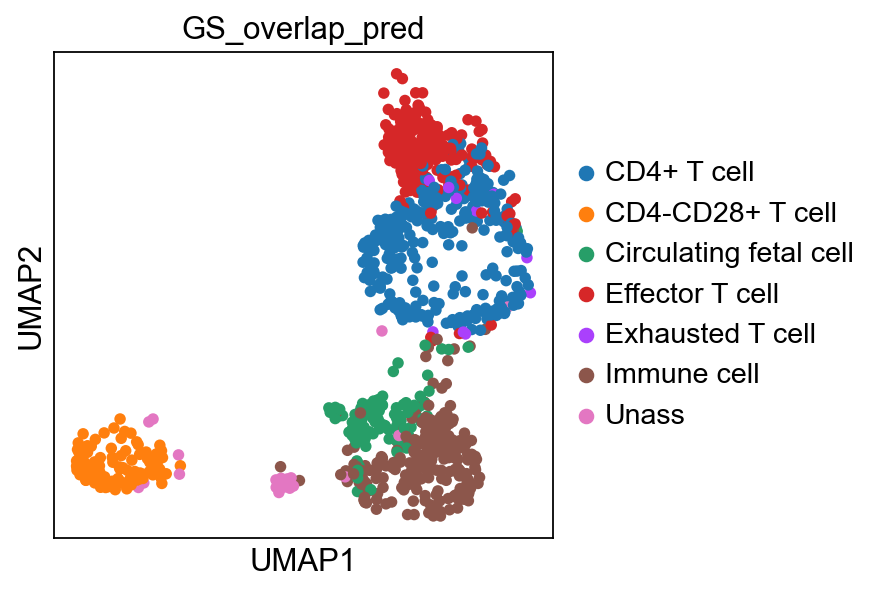

In [34]:
sc.pl.umap(adata, color='GS_overlap_pred')

## GSEA

In [35]:
gene_rank = sc.get.rank_genes_groups_df(adata, group='1', key='wilcoxon')[['names','logfoldchanges']]
gene_rank.head()

,names,logfoldchanges
0,LYAR,4.475473
1,DUSP2,6.442195
2,CD3D,3.514300
3,CCL5,18.013206
4,CD3E,4.522890


In [36]:
gene_dict = df.geneSymbol.str.split(",").to_dict()
gene_dict.keys()

dict_keys(['Kupffer cell', 'Monocyte', 'Natural killer cell', 'Mesenchymal stem cell', 'B cell', 'Adipose-derived stem cell', 'Nucleus pulposus cell', 'Urine-derived stem cell', 'Immune cell', 'Endothelial cell', 'Mesenchymal stromal cell', 'Myeloid-derived suppressor cell', 'Circulating fetal cell', 'Regulatory T (Treg) cell', 'Fibroblast', 'Cancer stem cell', 'T cell', 'Myeloid cell', 'Granulocyte', 'Classical monocyte', 'Intermediate monocyte', 'Non-classical monocyte', 'Suppressive monocyte', 'Monocyte derived dendritic cell', 'CD16+ dendritic cell', 'Immature myeloid cell', 'Neutrophil', 'Eosinophil', 'Unrestricted somatic stem cell', 'Endometrial stem cell', 'Oviduct-derived stem cell', 'Cancer stem-like cell', 'Photoreceptor cell', 'Pericyte', 'Adipose-derived stromal cell', 'Dental pulp stem cell', 'Liver stem cell', 'Pluripotent stem cell', 'CD4-CD28+ T cell', 'CD4-CD28- T cell', 'Dedifferentiation adipocyte', 'Cancer cell', 'Hematopoietic cell', 'Hematopoietic precursor cell'

gene_rank = sc.get.rank_genes_groups_df(adata, group='1', key='wilcoxon')[['names','logfoldchanges']]

res = gseapy.prerank(rnk=gene_rank, 
                     gene_sets=gene_dict,
                     processes=2,
                     min_size=5,
                     max_size=100,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='test/prerank_report_ct', format='png', seed=6)



res.res2d.sort_index().head()


There are many more methods for celltype predictions, both pretrained and based on a refernce dataset. Here was an example of two methods that can be used. Keep in mind that both what method you use, and what reference you chose will have an impact on the results.